In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from datetime import datetime
import os
import pickle
import tabulate
import wandb
from collections import defaultdict, namedtuple
from tqdm.notebook import tqdm

In [4]:
api = wandb.Api()

In [5]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save(save_path, bbox_inches='tight'):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        print('Figure:\n')
        print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('\nWrapfigure:\n')
        print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
        print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [6]:
CACHE_PATH = './results_cache.pickle'
BACKUP_CACHE_PATH = './results_cache_{date}.pickle'


def refresh_cache(new_values_dict=None, cache_path=CACHE_PATH):
    if new_values_dict is None:
        new_values_dict = {}
    
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as cache_file:
            cache = pickle.load(cache_file)
    
    else:
        cache = {}
    
    cache.update(new_values_dict)
    
    if os.path.exists(cache_path):
        os.rename(CACHE_PATH, BACKUP_CACHE_PATH.format(date=datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))

    with open(cache_path, 'wb') as cache_file:
        pickle.dump(cache, cache_file)

    return cache
 

cache = refresh_cache()

# Game plan
* Iterate through projects 
* Parse each project conditions from its name
* Aggregate each of the following statistics by model:
    * Peak accuracy
    * Epoch in which peak accuracy takes place
    * Epoch above some accuracy threshold
    * Did the model overfit (delta between train and val?)
* Start examining the effects of different manipulations:
    * Choice of relation
    * Number of objects
    * Size of the training set
    * Size of the model (in that one condition I ran larger)
* Probably more bar charts tables than anything else, unless we need learning curves



In [9]:
Condition = namedtuple('Condition', ('relation', 'model_config', 'num_objects', 'dataset_size', 'dataset_power'))


def name_to_condition(name):
    relation, model_config, num_objects, dataset_size = name.split('-')[::2]
    num_objects = int(num_objects)
    dataset_size = int(dataset_size)
    return Condition(relation=relation, model_config=model_config, num_objects=num_objects, 
                     dataset_size=dataset_size, dataset_power=int(np.log2(dataset_size)))


def parse_run(run, num_samples=10000, accuracy_threshold=0.95):
    history_df = run.history(samples=num_samples)
    run_results = {}
    
    max_accuracy_index = history_df.val_acc.idxmax()
    run_results['max_val_acc'] = history_df.val_acc[max_accuracy_index]
    run_results['max_val_acc_step'] = history_df.global_step[max_accuracy_index]
    
    accuracy_above_treshold_index = (history_df.val_acc >= accuracy_threshold).idxmax()
    if accuracy_above_treshold_index == 0:  # Never went above treshold
        run_results['acc_threshold_step'] = None
    else:
        run_results['acc_threshold_step'] = history_df.global_step[accuracy_above_treshold_index]
        
    run_results['acc_diff'] = history_df.train_acc.max() - history_df.val_acc.max()
    
    return run_results
    
    
def parse_project(project):
    uri = f'{project.entity}/{project.name}'
    runs = api.runs(uri)
    results_by_model = defaultdict(list)
    
    for run in tqdm(runs, desc='Runs'):
        seed_split_index = run.name.rindex('-')
        model_name = run.name[:seed_split_index]
        seed = int(run.name[seed_split_index + 1:])
        
        run_results = parse_run(run)
        run_results['seed'] = seed
        run_results['total_params'] = run.config['total_params']
        
        results_by_model[model_name].append(run_results)
        
    return results_by_model
        
        
def parse_all_projects(entity='simple-relational-reasoning'):
    projects = api.projects(entity)
    results = {}
    
    print(projects)
    for proj in tqdm([p for p in projects], desc='Projects'):
        condition = name_to_condition(proj.name)
        results[condition] = parse_project(proj)
        
    return results


if 'all_results' not in cache:
    cache['all_results'] = parse_all_projects()
    cache = refresh_cache(cache)
    
all_results = cache['all_results']

<Projects simple-relational-reasoning>


wandb: Network error resolved after 0:00:10.439788, resuming normal operation.


wandb: Network error resolved after 0:00:13.130396, resuming normal operation.


In [12]:
CONDITION_FIELDS = list(Condition._fields)
RUN_RESULTS_FIELDS = ['seed', 'total_params', 'max_val_acc', 'max_val_acc_step', 
                      'acc_threshold_step', 'acc_diff']
COLUMNS = CONDITION_FIELDS + ['model_name'] + RUN_RESULTS_FIELDS


def results_dict_to_df(results_dict):
    rows = []
    for condition, results_by_model in tqdm(results_dict.items(), desc='Condition'):
        condition_row_prefix = list(condition)
        for model_name, results_by_seed in tqdm(results_by_model.items(), desc='Result'):
            for run_results in results_by_seed:
                run_result_list = [run_results[field] for field in RUN_RESULTS_FIELDS]
                rows.append(condition_row_prefix + [model_name] + run_result_list)
                
    return pd.DataFrame(rows, columns=COLUMNS)


if 'all_results_df' not in cache:
    cache['all_results_df'] = results_dict_to_df(all_results)
    cache = refresh_cache(cache)
    
all_results_df = cache['all_results_df']

# Plotting thoughts
* I want a single plotting function that will generate a group of bar charts
* Steps:
    1. Filter out particular parts of the dataframe.
    2. Group by one or more fields.
    3. Aggregate (mean, sd) the metric of choice.
    4. Group the bars by one of the group-by fields. 
* I probably want some way to specify formatting by the individual groups left (for example, a color for each model, a striping for each relation, ...)

**TODO:** 
* Pretitfy names
* Model (or other field orders)

In [27]:
DEFAULT_ORDERS = {
    'model_name': ['combined-object-mlp', 'cnn', 'relation-net', 'transformer'],
    'relation': ['adjacent', 'above', 'count']
}
DEFAULT_COLORMAP = plt.get_cmap('Dark2')
DEFAULT_BAR_KWARGS_BY_FIELD = defaultdict(lambda: defaultdict(dict))
DEFAULT_BAR_KWARGS_BY_FIELD['model_name'] = {name: {'color': DEFAULT_COLORMAP(i)}
                                             for i, name in enumerate(DEFAULT_MODEL_ORDER)}
DEFAULT_TEXT_KWARGS = {
    'fontsize': 16
}

PRETTY_NAMES = {
    'cnn': 'CNN',
    'combined-object-mlp': 'MLP',
    'relation-net': 'RelationNet',
    'max_val_acc': 'Validation Accuracy'
}


def prettify(text):
    if text in PRETTY_NAMES:
        return PRETTY_NAMES[text]

    return text.lower().title()


def create_bar_chart(df, filter_dict, group_by_fields, metric, major_group_by, 
                     orders=DEFAULT_ORDERS, sem=True, title=None,
                     bar_kwargs_by_field=DEFAULT_BAR_KWARGS_BY_FIELD,
                     bar_width=0.2, bar_spacing=0.5, default_bar_kwargs=None,
                     text_kwargs=DEFAULT_TEXT_KWARGS):
    
    group_by_fields = list(group_by_fields)
    assert(len(group_by_fields) == 2)
    assert(major_group_by in group_by_fields)
    minor_group_by = group_by_fields[1 - group_by_fields.index(major_group_by)]
    
    if default_bar_kwargs is None:
        default_bar_kwargs = dict()
    
    filtered_df = df
    
    if filter_dict is not None:
        for filter_name, filter_value in filter_dict.items():
            filtered_df = filtered_df[filtered_df[filter_name].eq(filter_value)]
            
    grouped_df = filtered_df.groupby(group_by_fields)
    mean = grouped_df[metric].mean()
    std = grouped_df[metric].std()
    if sem:
        std /= np.sqrt(grouped_df[metric].count())

    if major_group_by in orders:
        major_group_values = orders[major_group_by]
    else:
        major_group_values = mean.index.unique(level=major_group_by)
        
    if minor_group_by in orders:
        minor_group_values = orders[minor_group_by]
    else:
        minor_group_values = mean.index.unique(level=minor_group_by)
    
    major_kwargs = bar_kwargs_by_field[major_group_by]
    minor_kwargs = bar_kwargs_by_field[minor_group_by]
    
    
    figure = plt.figure(figsize=(8, 6))
    x = 0
    
    for major_level_value in major_group_values:
        major_level_kwargs = major_kwargs[major_level_value]
        
        for minor_level_value in minor_group_values:
            minor_level_kwargs = minor_kwargs[minor_level_value]
            
            m = mean.loc[(major_level_value, minor_level_value)]
            s = std.loc[(major_level_value, minor_level_value)]
            plt.bar(x, m, yerr=s, width=bar_width, **major_level_kwargs, **minor_level_kwargs, **default_bar_kwargs)
            
            x += bar_width
        
        x += bar_spacing
        
    x_tick_locations = np.arange(len(major_group_values)) * (bar_spacing + bar_width * len(minor_group_values)) +\
                        bar_width * (len(minor_group_values) / 2 - 0.5)
    plt.xticks(x_tick_locations, [prettify(str(val)) for val in major_group_values], **text_kwargs)
    plt.xlabel(prettify(major_group_by), **text_kwargs)
    plt.ylabel(prettify(metric), **text_kwargs)
    plt.title(title)
    
    patches = []
    ncol = 0
    for kwarg_set in (major_kwargs, minor_kwargs):
        if any([len(val) > 0 for val in kwarg_set.values()]):
            ncol += 1
            for field_value in kwarg_set:
                patches.append(matplotlib.patches.Patch(**kwarg_set[field_value], label=prettify(field_value)))
    
    if len(patches) > 0: 
        plt.legend(handles=patches, loc='best', ncol=ncol)
    
    plt.show()
    

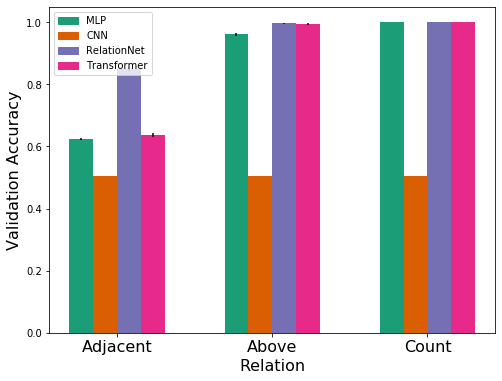

In [28]:
create_bar_chart(all_results_df, 
                 filter_dict=dict(model_config='default', num_objects=5, dataset_power=14), 
                 group_by_fields=('relation', 'model_name'),
                 metric='max_val_acc',
                 major_group_by='relation')


In [ ]:
partial_df.groupby('model_name').mean()

In [ ]:
for relation in ('adjacent', 'above', 'count'):
    d = partial_df[partial_df['relation'] == relation]
    print(d.head())
    print(d.groupby('model_name').max_val_acc.mean())

In [ ]:
partial_df.groupby(['relation', 'model_name']).mean()

In [16]:
'hello world'.title()

'Hello World'

In [ ]:
partial_df.head()

In [ ]:
partial_df.tail()

In [ ]:
d = all_results_df.copy()

In [ ]:
e = d[d['relation'].eq('adjacent')]

In [ ]:
d.shape, e.shape

In [ ]:
g = e.groupby(['num_objects', 'model_name'])

In [ ]:
np.sqrt(g['relation'].count())

In [ ]:
r = g.max_val_acc.mean()

In [ ]:
r.index.unique()

In [ ]:
r.loc[(5, 'cnn')]

In [ ]:
r.index.get_level_values('num_objects')

In [ ]:
history_df = r.history(samples=10000)

In [ ]:
history_df.columns

In [ ]:
history_df.val_acc.idxmax()

In [ ]:
history_df.iloc[3545]

In [ ]:
history_df.iloc[:25]

In [ ]:
2 => 1
5 => 2
8 => 3

In [ ]:
h2 = runs[28].history()
h2[:20]

In [ ]:
h2.val_acc.isnull().sum()

In [ ]:
history_df.val_acc[:501].isnull().sum()

In [ ]:
(h2.val_acc > 0.8).idxmax()

In [ ]:
h2.train_acc.max() - h2.val_acc.max()